# Generate input files for VASP core-hole potential calculations

The class `CHPCalculation` can be used to generate VASP input files for XAS simulations with the supercell core-hole approach [1].  See the [VASP Wiki](https://www.vasp.at/wiki/index.php/XAS_theory) for further details.  In the example below, Pymatgen [2] is used to read an input structure of a lithium thiophosphate with composition Li$_7$P$_3$S$_{11}$.  Pymatgen is also used internally to write out VASP input files.

[1] F. Karsai, M. Humer, E. Flage-Larsen, P. Blaha and G. Kresse, [*Phys. Rev. B* **98**, 235205 (2018)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.98.235205).<br/>
[2] S. P. Ong et al., [*Comput. Mater. Sci.* **68**, 314–319 (2013)](https://doi.org/10.1016/j.commatsci.2012.10.028).

In [1]:
from pymatgen.io.vasp import Poscar
struc = Poscar.from_file("./data/CONTCAR_Li7P3S11").structure

We initialize a core-hole potential calculation for the sulfur K edge (quantum numbers $n=1, \ell = 0$) and a full core hole ($z = 1.0$ electron).

In [2]:
from xas_tools.vasp import CHPCalculation
chp = CHPCalculation(struc, element="S", n=1, ell=0, z=1.0)

For the VASP calculation, we create a $1\times{}2\times1$ supercell.  The number of bands is set to twice the number of electrons.  And an explicit path for the generated input files is specified.

**Note:** Pymatgen needs to be set-up correctly for this to work.  Specifically, the location of the pseudopotential files needs to be known to Pymatgen.

**Also note:** The method `write_vasp_input` accepts a number of optional arguments, for example, for parallelization and to specify different VASP input sets.  The default input set sets up calculations within the local density approximation (LDA).

In [ ]:
xas_yaml = "path-to-costum/LDA-XAS" # path to LDA-XAS.yaml you want to use
chp.write_vasp_input(supercell=(1,2,1), band_multiple=2, path='Li7P3S11_chp_input', vasp_set=xas_yaml)
%ls ./Li7P3S11_chp_input
%ls ./Li7P3S11_chp_input/XAS_input_01_1

/home/user/anaconda3/envs/mycode/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/user/anaconda3/envs/mycode/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


metadata.json    XAS_input_04_1/  XAS_input_08_1/  XAS_input_SCF/
XAS_input_01_1/  XAS_input_05_1/  XAS_input_09_1/
XAS_input_02_1/  XAS_input_06_1/  XAS_input_10_1/
XAS_input_03_1/  XAS_input_07_1/  XAS_input_11_1/
INCAR  KPOINTS  POSCAR  POTCAR


Each generated subdirectory contains all input files that are needed for VASP calculations. The directory named `XAS_input_SCF` contains input files for a ground-state calculation without core hole.  Note that the generated files are not shared in the GitHub repository because the pseudopotential files that require a VASP license.  Additional information is stored in the file `metadata.json`:

In [7]:
import json
with open('./Li7P3S11_chp_input/metadata.json') as fp:
    metadata = json.load(fp)
print(json.dumps(metadata, indent=4, sort_keys=True))

{
    "active_atom_types": [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11
    ],
    "angular_quantum_number": 0,
    "band_multiple": 2,
    "corehole_electron_count": 1.0,
    "grid_points": 40000,
    "main_quantum_number": 1,
    "multiplicity": [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ],
    "smearing": 0.05,
    "supercell": [
        1,
        2,
        1
    ],
    "valence_electrons": 352,
    "xas_element": "S"
}


The structure does not exhibit symmetry, so that one calculation per S atom needs to be performed.  In the case of symmetric structures, the multiplicity of each equivalent atom is determined automatically.  In the following example, the first S atom has a multiplicity of 2.

In [10]:
struc2 = Poscar.from_file("./data/CONTCAR_Li3PS4").structure
chp2 = CHPCalculation(struc2, element="S", n=1, ell=0, z=1.0)
chp2.write_vasp_input(supercell=(1,2,1), band_multiple=2, path='Li3PS4_chp_input', vasp_set=xas_yaml)
%ls ./Li3PS4_chp_input
%cat ./Li3PS4_chp_input/metadata.json

/home/user/anaconda3/envs/mycode/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/user/anaconda3/envs/mycode/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


metadata.json  XAS_input_1_2/  XAS_input_2_1/  XAS_input_3_1/  XAS_input_SCF/
{"xas_element": "S", "valence_electrons": 128, "supercell": [1, 2, 1], "band_multiple": 2, "grid_points": 40000, "smearing": 0.05, "main_quantum_number": 1, "angular_quantum_number": 0, "corehole_electron_count": 1.0, "active_atom_types": [1, 2, 3], "multiplicity": [2, 1, 1]}

# Process output from VASP CHP calculations

Postprocessing steps

- Extract the XAS data from the OUTCAR files (imaginary part of the dielectric function)
- Align the XAS spectra by applying the shift $(E_{\mathrm{tot}}^{\mathrm{ch}} - E_{\mathrm{tot}}^{\mathrm{no ch}})$

In [11]:
from xas_tools.vasp import parse_vasp_chp_output

The following line extracts and postprocesses the XAS lines from all subdirectories with CHP calculations.  For each XAS line, a CSV file will be generated.  Additionally, a JSON file named `metadata.json` will be created that contains additional details of the calculation.

In [12]:
parse_vasp_chp_output('./data/Li7P3S11')

# Visualization and analysis

In [13]:
from xas_tools.spectra import AbsorptionSpectrum

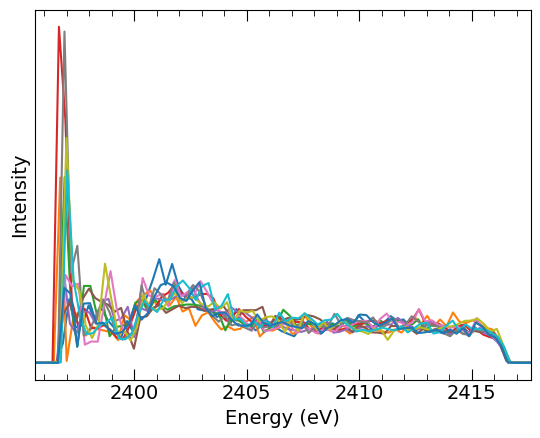

In [14]:
spectrum = AbsorptionSpectrum('XAS_output/structure_1')
spectrum.plot_atomic_lines();

In [21]:
# broadening of the calculated spectra
gauss = 0.3  # FWHM for Gaussian broadening
lorentz = [0.1, 0.5]  # linearly increasing FWHM for Lorentzian broadening
spectrum.calculate_broadened(gauss, lorentz[0], lorentz[1], 
                              energy_range=(None, 2420), dE=2.0, n=200)

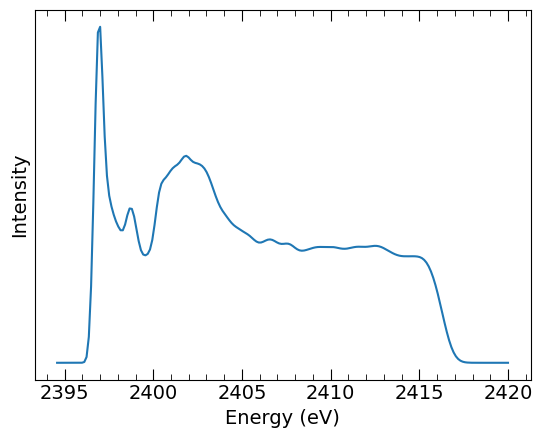

In [24]:
fig, ax = spectrum.plot_broadened()
ax.set_xlim(None, None)
import matplotlib.pyplot as plt
plt.savefig("Li7P3S11.pdf", bbox_inches='tight')